# ***Where is the Chef From?***

In this project we aim to predict the category of a dish's cuisine given a list of its ingredients.  Food is such a large part of the daily human experience.  Our strongest geographic and cultural associations are tied to a region’s local foods.  Linking recipes to the country of origin is valuable, especially under multiclass classification conditions. 


‘’If you're in Northern California, you'll be walking past the inevitable bushels of leafy greens, spiked with dark purple kale and the bright pinks and yellows of chard. Across the world in South Korea, mounds of bright red kimchi greet you, while the smell of the sea draws your attention to squids squirming nearby. India’s market is perhaps the most colorful, awash in the rich hues and aromas of dozens of spices: turmeric, star anise, poppy seeds, and garam masala as far as the eye can see. Some of our strongest geographic and cultural associations are tied to a region's local foods.’’

The dataset is from Kaggle challenge: What’s for dinner? The data are stored in JSON format.
train.json - the training set containing recipes id, type of cuisine, and list of ingredients
test.json - the test set containing recipes id, and list of ingredients
https://www.kaggle.com/kaggle/recipe-ingredients-dataset/home


Import the required packages.

In [16]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib as plt

### **Data Load and Analysis**

Read the dataset. The data is in json format.

In [17]:
dataset = pd.read_json('https://s3.amazonaws.com/chef2018/train.json', orient='records')

Print the total number of recipes in the dataset.

In [18]:
print("Number of recipes:", len(dataset))

Number of recipes: 39774


Let's look at first ten rows of data. Each recipe has a unique id, country of origin label (cusine) and list of ingredients.

In [19]:
dataset[:10]

,cuisine,id,ingredients
0,greek,10259,"[romaine lettuce, black olives, grape tomatoes..."
1,southern_us,25693,"[plain flour, ground pepper, salt, tomatoes, g..."
2,filipino,20130,"[eggs, pepper, salt, mayonaise, cooking oil, g..."
3,indian,22213,"[water, vegetable oil, wheat, salt]"
4,indian,13162,"[black pepper, shallots, cornflour, cayenne pe..."
5,jamaican,6602,"[plain flour, sugar, butter, eggs, fresh ginge..."
6,spanish,42779,"[olive oil, salt, medium shrimp, pepper, garli..."
7,italian,3735,"[sugar, pistachio nuts, white almond bark, flo..."
8,mexican,16903,"[olive oil, purple onion, fresh pineapple, por..."
9,italian,12734,"[chopped tomatoes, fresh basil, garlic, extra-..."


Let's look at a specific example. Ingredients of roti (indian bread).

In [20]:
roti = (dataset['id'] == 22213)
dataset[roti][['ingredients']]

,ingredients
3,"[water, vegetable oil, wheat, salt]"


Count of recipes by cusines and plot bar chart of count of recipes for each cuisine.

In [21]:
cuisine = dataset['cuisine'].value_counts().index  #for evaluation purpose, do not delete
dataset['cuisine'].value_counts()

italian         7838
mexican         6438
southern_us     4320
indian          3003
chinese         2673
french          2646
cajun_creole    1546
thai            1539
japanese        1423
greek           1175
spanish          989
korean           830
vietnamese       825
moroccan         821
british          804
filipino         755
irish            667
jamaican         526
russian          489
brazilian        467
Name: cuisine, dtype: int64

Text(0, 0.5, '# Recipes')

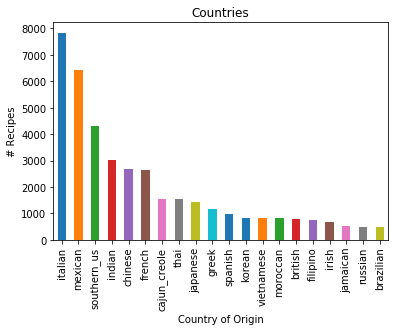

In [22]:
ax = dataset['cuisine'].value_counts().plot(kind='bar', \
                                            title="Countries")
ax.set_xlabel("Country of Origin")
ax.set_ylabel("# Recipes")

Let's collect all the ingredients in a list and print few examples.


In [23]:
ingredients = []
for il in dataset['ingredients']:
    ingredients.extend(il)
print("Total ingredients (not unique):", len(ingredients))
print("Total unique ingredients:", len(set(ingredients)))

for i in range(10):
    print(ingredients[i])

Total ingredients (not unique): 428275
Total unique ingredients: 6714
romaine lettuce
black olives
grape tomatoes
garlic
pepper
purple onion
seasoning
garbanzo beans
feta cheese crumbles
plain flour


Let's find top 10 ingredients across all recipes and plot.



Text(0, 0.5, '# Recipes')

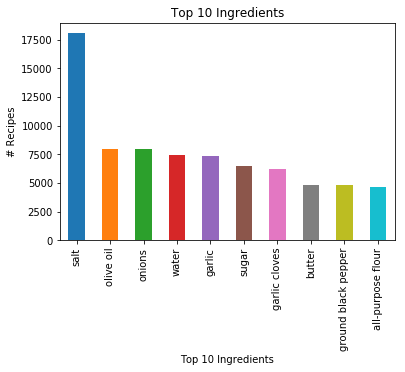

In [24]:
ingredients_series = pd.Series(ingredients)
ax1 = ingredients_series.value_counts().head(10).plot(kind='bar', \
                                               title='Top 10 Ingredients')
ax1.set_xlabel("Top 10 Ingredients")
ax1.set_ylabel("# Recipes")

Ingredient Importance - garlic



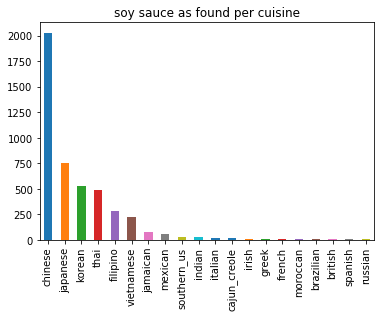

In [25]:
ingredients2 = dataset['ingredients'].map(";".join)
indices = ingredients2.str.contains('soy sauce')
dataset[indices]['cuisine'].value_counts().plot(kind='bar',
                                   title='soy sauce as found per cuisine')

### **Data cleaning**

As we can see that some of the ingredients have words describing some attributes of the underlying ingredient.  
There are two cases we need to deal with:

For example, "chopped onions" vs "onions". The word chopped doesn't add any value to learning so we can remove the word "chopped".

Another case "garlic clove" and "garlic".  In this case, we can't just remove "clove" since it is also a name of an ingredient.  We deal with this case as mapping "garlic clove" to "garlic".

Additionally, we see examples such as "eggs" and "egg". Therefore we convert purals to singulars.

Finally, we replace one than one spaces to a single space and remove space in the start and end.


In [26]:
import re
def clean_ingredients(ingredients):
  
  words_to_remove = ["lowfat", "light", "shredded", "sliced", "all purpose", "all natural", "natural", "original", 
                      "gourmet", "traditional", "boneless", "skinless", "fresh", "nonfat", "pitted", "quick cooking", 
                      "unbleached", "part skim", "skim", "quickcooking", "oven ready", "homemade", "instant", "small", 
                      "extra large", "large", "chopped", "grated", "cooked", "stone ground", "freshly ground", 
                      "ground", "pure", "peeled", "deveined", "organic", "cracked", "granulated", "inch thick", 
                      "extra firm", "crushed", "flakes", "self rising", "diced", "crumbles", "crumbled", 
                      "whole wheat", "whole grain", "baby", "medium", "plain", "of", "thick cut", "cubed", "coarse", 
                      "free range", "seasoned", "canned", "multipurpose", "vegan", "thawed", "squeezed", 
                      "vegetarian", "fine", "zesty", "halves", "firmly packed", "drain", "drained", "washed"]
  
  map_plural_to_singular = [("steaks", "steak"), ("loins", "loin"), ("inches", "inch"), ("centimeters", "centimeter"),
                          ("ounces", "ounce"), ("liters", "liter"), ("mililiters", "mililiter"), ("grams", "gram"),
                          ("cups", "cup"), ("gallons", "gallon"), ("quarts", "quart"), ("lbs", "lb"),
                          ("pounds", "pound"), ("tablespoons", "tablespoon"), ("teaspoons", "teaspoon"), 
                          ("pints", "pint"), ("fluid ounces", "fluid ounce"), ("onions", "onion"), 
                          ("cloves", "clove"), ("bulbs", "bulb"), ("peppers", "pepper"), ("breasts", "breast"),
                          ("eggs", "egg"), ("carrots", "carrot"), ("mushrooms", "mushroom"),
                          ("tortillas", "tortilla"), ("sausages", "sausage"), ("wedges", "wedge"), 
                          ("tomatoes", "tomato"), ("thighs", "thigh"), ("chilies", "chili"), ("potatoes", "potato"), 
                          ("peppercorns", "peppercorn"), ("spices", "spice"), ("chiles", "chile"), ("apples", "apple"),
                          ("legs", "leg"), ("doughs", "dough"), ("drumsticks", "drumstick")]
  
  phrases_to_map = [
    (("green onion", "red onion", "purple onion", "yellow onion", "yel onion"), "onion"),
    (("collard green leaves", "collards", "collard leaves"), "collard greens"),
    ("black pepper", "pepper"),
    ("yel chives", "chives"),
    ("spinach leaves", "spinach"),
    ("tea leaves", "tea"),
    ("chile", "chili"),
    (("garlic clove", "garlic bulb"), "garlic"),
    ("uncooked", "raw"),
    (("red chili pepper", "hot chili pepper", "red hot chili pepper"), "chili pepper"),
    (("baking potato", "baked potato"), "baked potato"),
    (("sea salt", "kosher salt", "table salt", "white salt"), "salt"),
    ("scotch whiskey", "scotch"),
    (("i cant believe its not butter spread", "i cant believe its not butter"), "butter"),
    (("extra virgin olive oil", "virgin olive oil"), "olive oil"),
    (("white bread", "wheat bread", "grain bread"), "bread"),
    (("white sugar", "yel sugar"), "sugar"),
    ("confectioners sugar", "powdered sugar")
    ]
  
  for i in range(len(ingredients)):
    for word in words_to_remove:
        ingredients[i] = re.sub(r"\b{}\b".format(word), "", ingredients[i])
    for plural, singular in map_plural_to_singular:
        ingredients[i] = re.sub(r"\b{}\b".format(plural), singular, ingredients[i])
    for pattern, replacement in phrases_to_map:
        if type(pattern) is tuple:
            for val in pattern:
                ingredients[i] = re.sub(r"\b{}\b".format(val), replacement, ingredients[i])
        elif type(pattern) is str:
            ingredients[i] = re.sub(r"\b{}\b".format(pattern), replacement, ingredients[i])
    ingredients[i] = re.compile(r" +").sub(" ", ingredients[i])
    ingredients[i] = ingredients[i].strip()


### **Design Matrix**

Prepare design matrix and labels. Split the data into train and test sets.

In [27]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder

ingredients = [' '.join(ingredients).lower() for ingredients in dataset['ingredients']]
cuisines = [cusine for cusine in dataset['cuisine']]
#clean_ingredients(ingredients)

tfidf_enc = TfidfVectorizer(binary=True)
lbl_enc = LabelEncoder()

X = tfidf_enc.fit_transform(ingredients)
X = X.astype('float16')

Y = lbl_enc.fit_transform(cuisines)

x_train, x_test, y_train, y_test = train_test_split(X, Y,
                                                    test_size=0.05,
                                                    random_state = 8888)

print("x_train", x_train.shape)
print("y_train", y_train.shape)
print("x_test", x_test.shape)
print("y_test", y_test.shape)



x_train (37785, 3010)
y_train (37785,)
x_test (1989, 3010)
y_test (1989,)


### **Evaluation Matrix**

In [28]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from matplotlib import pyplot

def cm(y_test, y_pred, cuisines):         
    pyplot.figure(figsize=(10, 10))
    cm = confusion_matrix(y_test, y_pred)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    pyplot.imshow(cm_normalized, interpolation='nearest')
    pyplot.title("confusion matrix")
    pyplot.colorbar(shrink=0.2)
    tick_marks = np.arange(len(cuisines))
    pyplot.xticks(tick_marks, cuisines, rotation=90)
    pyplot.yticks(tick_marks, cuisines)
    pyplot.tight_layout()
    pyplot.ylabel('True label')
    pyplot.xlabel('Predicted label')
    
    print(classification_report(y_test, y_pred, target_names = cuisines))




### **Multi-layer Perceptron classifier - Base Case 1**

training accuracy: 0.8492523488156676
testing accuracy: 0.770739064856712
              precision    recall  f1-score   support

     italian       0.67      0.56      0.61        18
     mexican       0.50      0.36      0.42        39
 southern_us       0.76      0.69      0.72        74
      indian       0.82      0.83      0.82       145
     chinese       0.59      0.71      0.65        31
      french       0.57      0.63      0.60       134
cajun_creole       0.88      0.73      0.80        63
        thai       0.83      0.91      0.87       144
    japanese       0.53      0.55      0.54        38
       greek       0.83      0.86      0.85       404
     spanish       0.67      0.71      0.69        14
      korean       0.65      0.63      0.64        68
  vietnamese       0.70      0.82      0.76        40
    moroccan       0.91      0.91      0.91       345
     british       0.83      0.78      0.80        45
    filipino       0.41      0.32      0.36        22
       

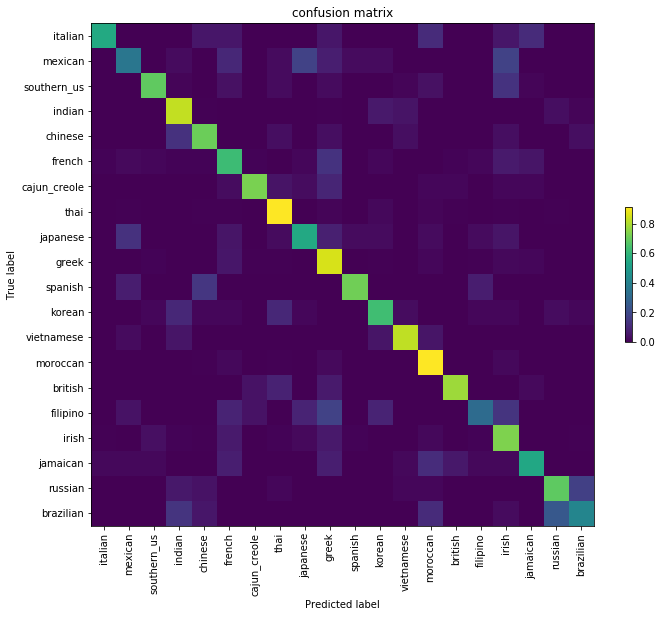

In [29]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score

mlp_clf = MLPClassifier(solver='lbfgs', alpha=1e-3,
                     hidden_layer_sizes=(128, 64), random_state=1)

mlp_clf.fit(x_train, y_train)                         

y_pred1 = mlp_clf.predict(x_train)
y_pred2 = mlp_clf.predict(x_test)

print("training accuracy:", accuracy_score(y_train, y_pred1))
print("testing accuracy:", accuracy_score(y_test, y_pred2))
cm(y_test, y_pred2, cuisine)



### **Logistic Regression - Base Case 2**
Optimum hyperparameter grid search.

--before optimization--


/Users/manishpandit/.local/share/virtualenvs/chef-k36W3vhI/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/manishpandit/.local/share/virtualenvs/chef-k36W3vhI/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


testing accuracy: 0.792357968828557
--after optimization--


/Users/manishpandit/.local/share/virtualenvs/chef-k36W3vhI/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/manishpandit/.local/share/virtualenvs/chef-k36W3vhI/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


CV training accuracy: 0.7889 (+/- 0.0097)
testing accuracy: 0.8024132730015083
              precision    recall  f1-score   support

     italian       0.91      0.56      0.69        18
     mexican       0.62      0.46      0.53        39
 southern_us       0.76      0.65      0.70        74
      indian       0.82      0.86      0.84       145
     chinese       0.65      0.65      0.65        31
      french       0.61      0.67      0.64       134
cajun_creole       0.90      0.68      0.77        63
        thai       0.88      0.93      0.90       144
    japanese       0.74      0.45      0.56        38
       greek       0.83      0.91      0.87       404
     spanish       0.85      0.79      0.81        14
      korean       0.80      0.71      0.75        68
  vietnamese       0.82      0.80      0.81        40
    moroccan       0.92      0.93      0.92       345
     british       0.92      0.73      0.81        45
    filipino       0.62      0.36      0.46        22
  

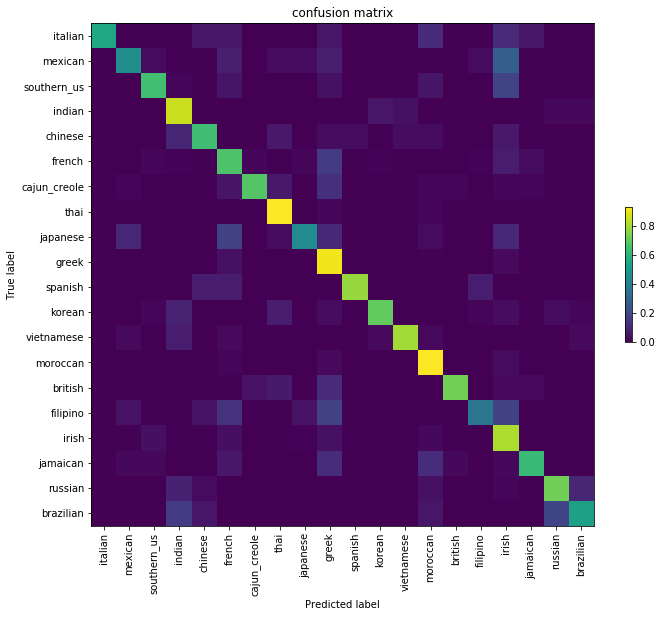

In [30]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

y_train = y_train.reshape(y_train.size)
purpose = 'run'    #optimize or run(get best results)

if purpose == 'optimize':
    lr = LogisticRegression(C=10)
    lr.fit(x_train, y_train)
  
    #cv  
    scores = cross_val_score(LogisticRegression(C=10), x_train ,y_train, cv=5)
    print("training accuracy: %0.4f (+/- %0.4f)" % (scores.mean(), scores.std() * 2))
    y_pred1 = lr.predict(x_test)
    print("testing accuracy before Grid Search:", accuracy_score(y_test, y_pred1))

    #grid search
    parameters = {'C':[0.1,0.5,1,1.5,2,2.5,3,3.5,4,4.5,5,5.5,6,6.5,7,7.5,8,8.5,9,9.5,10]}
    lr_clf = GridSearchCV(lr, parameters)
    lr_clf.fit(x_train, y_train)

    # predict cuisines
    y_pred2 = lr_clf.predict(x_test)
    print("testing accuracy after Grid Seach:", accuracy_score(y_test, y_pred2))
    # best parameter C=4.5 - test accuracy 80.1408%
    print(lr_clf.best_estimator_)
else:
    print("--before optimization--")
    lr = LogisticRegression()
    lr.fit(x_train, y_train)
    y_pred1 = lr.predict(x_test)
    print("testing accuracy:", accuracy_score(y_test, y_pred1))
    
    print("--after optimization--")
    lr_clf = LogisticRegression(C=4.5)
    lr_clf.fit(x_train, y_train)
    scores = cross_val_score(lr_clf, x_train ,y_train, cv=5)
    print("CV training accuracy: %0.4f (+/- %0.4f)" % (scores.mean(), scores.std() * 2))
    y_pred2 = lr_clf.predict(x_test)
    print("testing accuracy:", accuracy_score(y_test, y_pred2))
    cm(y_test, y_pred2, cuisine)

### **Support Vector Machine - Best Case**
Optimum hyperparameter grid search.

--before optimization--
testing accuracy: 0.7998994469582705
--after optimization--
CV training accuracy: 0.8055 (+/- 0.0090)
testing accuracy: 0.8205128205128205
              precision    recall  f1-score   support

     italian       0.92      0.61      0.73        18
     mexican       0.68      0.49      0.57        39
 southern_us       0.82      0.72      0.76        74
      indian       0.87      0.85      0.86       145
     chinese       0.85      0.74      0.79        31
      french       0.60      0.73      0.66       134
cajun_creole       0.89      0.78      0.83        63
        thai       0.88      0.93      0.90       144
    japanese       0.88      0.55      0.68        38
       greek       0.83      0.91      0.87       404
     spanish       0.73      0.79      0.76        14
      korean       0.81      0.74      0.77        68
  vietnamese       0.89      0.82      0.86        40
    moroccan       0.93      0.92      0.92       345
     british       0.92   

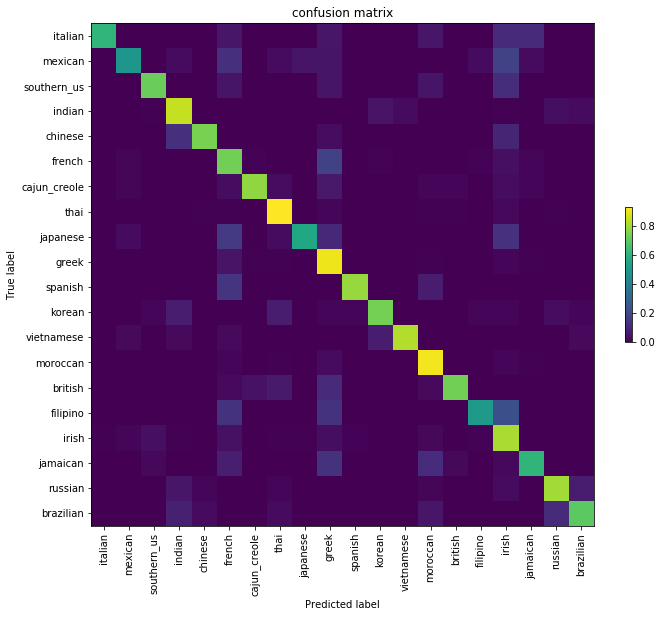

In [31]:
from sklearn import svm
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

y_train = y_train.reshape(y_train.size)
purpose = 'run'    #optimize or run(get best results)

if purpose == 'optimize':
    #---------1.Linear SVM-------------#
    lsvm = svm.LinearSVC(C=7)
    lsvm.fit(x_train, y_train)

    # cv  
    scores = cross_val_score(svm.LinearSVC(C=7), x_train ,y_train, cv=5)
    print("training accuracy: %0.4f (+/- %0.4f)" % (scores.mean(), scores.std() * 2))
    y_pred1 = lsvm.predict(x_test)
    print("testing accuracy 1 before Grid Search:", accuracy_score(y_test, y_pred1))

    # grid search
    parameters = {'C':[0.1,0.5,1,2,3,4,5,6,7,8,9,10]}
    clf_svm1 = GridSearchCV(lsvm, parameters)
    clf_svm1.fit(x_train, y_train)

    # predict cuisines
    y_pred2 = clf_svm1.predict(x_test)
    print("testing accuracy 1 after Grid Seach:", accuracy_score(y_test, y_pred2))
    #clf.get_params()

    #---------2.SVM-------------#
    # grid search
    param_grid = [{'C': [0.1, 1, 10], 'kernel': ['linear']},{'C': [0.1, 1, 10], 'gamma': [0.001, 0.01, 0.1, 1], 'kernel': ['rbf']},]
    svm_kern = svm.SVC()
    clf_svm2 = GridSearchCV(svm_kern, param_grid)
    clf_svm2.fit(x_train, y_train)
    svm_kern.fit(x_train, y_train)

    # predict cuisines
    y_pred3= clf_svm2.predict(x_test)
    print("testing accuracy 2 after Grid Seach:", accuracy_score(y_test, y_pred3))
    #clf2.get_params()

    #---------3.SVM extension-------------#
    # extend parameter grid
    param_grid2 = [{'C': [5, 10, 50, 100, 1000], 'gamma': [0.5, 1, 10, 100, 1000], 'kernel': ['rbf']}]
    svm_kern_2 = svm.SVC()
    clf_svm3 = GridSearchCV(svm_kern_2, param_grid2)
    clf_svm3.fit(x_train, y_train)

    # predict cuisines
    y_pred4= clf_svm3.predict(x_test)
    print("testing accuracy 3 after Grid Seach:", accuracy_score(y_test, y_pred4))
    #clf2.get_params()
else:
    print("--before optimization--")
    lsvm = svm.LinearSVC()
    lsvm.fit(x_train, y_train)
    y_pred1 = lsvm.predict(x_test)
    print("testing accuracy:", accuracy_score(y_test, y_pred1))
    
    print("--after optimization--")
    #best parameter C=10, gamma=1, kernel='rbf' -  - test accuracy 82.1016%
    svm_clf = svm.SVC(C = 10, kernel = 'rbf', gamma = 1)
    svm_clf.fit(x_train, y_train)
    scores = cross_val_score(svm_clf, x_train ,y_train, cv=5)
    print("CV training accuracy: %0.4f (+/- %0.4f)" % (scores.mean(), scores.std() * 2))
    y_pred2 = svm_clf.predict(x_test)
    print("testing accuracy:", accuracy_score(y_test, y_pred2))
    cm(y_test, y_pred2, cuisine)

### **Decision Tree Classifier - Other Case 1**

In [32]:
from sklearn.tree import DecisionTreeClassifier 
from sklearn.metrics import accuracy_score

rf_clf = DecisionTreeClassifier()
rf_clf.fit(x_train, y_train)
y_pred1 = rf_clf.predict(x_train)
y_pred2 = rf_clf.predict(x_test)

print("training accuracy:", accuracy_score(y_train, y_pred1))
print("testing accuracy:", accuracy_score(y_test, y_pred2))


training accuracy: 0.9996294825989149
testing accuracy: 0.6515837104072398


### **Passive Aggressive Classifier - Other Case 2**

In [33]:
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.metrics import accuracy_score

pa_clf = PassiveAggressiveClassifier(C = 0.5, max_iter = 1000, tol = 1e-5, loss = 'squared_hinge')
pa_clf.fit(x_train, y_train)
y_pred1 = pa_clf.predict(x_train)
y_pred2 = pa_clf.predict(x_test)

# test accuracy 77%
print("training accuracy:", accuracy_score(y_train, y_pred1))
print("testing accuracy:", accuracy_score(y_test, y_pred2))

training accuracy: 0.8547571787746461
testing accuracy: 0.7536450477626948


### **Random Forest - Other Case 3**


In [34]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

y_train = y_train.reshape(y_train.size)

rf_clf = RandomForestClassifier(n_estimators=1000, criterion = 'entropy',
                                max_depth=20)
rf_clf.fit(x_train, y_train)

y_pred1 = rf_clf.predict(x_train)
y_pred2 = rf_clf.predict(x_test) 

print("training accuracy:", accuracy_score(y_train, y_pred1))
print("testing accuracy:", accuracy_score(y_test, y_pred2))

training accuracy: 0.7831679237792775
testing accuracy: 0.6601307189542484


### **Multiple Naive Bayes - Other Case 4**
Optimum hyperparameter grid search.

In [35]:
from sklearn.naive_bayes import BernoulliNB, MultinomialNB#, ComplementNB
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV

def run_NB(nb_clf):
  
    nb_clf.fit(x_train, y_train)
    y_pred1 = nb_clf.predict(x_train)
    y_pred2 = nb_clf.predict(x_test) 

    print(nb_clf)
    print("training accuracy:", accuracy_score(y_train, y_pred1))
    print("testing accuracy:", accuracy_score(y_test, y_pred2))


#run_NB(BernoulliNB(alpha=.01))
#run_NB(ComplementNB(alpha=.1))

y_train = y_train.reshape(y_train.size)
purpose = 'run'    #optimize or run(get best results)

if purpose == 'optimize':
    nb = MultinomialNB()
    parameters = {'alpha':[0.001,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65,0.7,0.75,0.8,0.85,0.9,0.95,1]}
    nb_clf = GridSearchCV(nb, parameters)
    nb_clf.fit(x_train, y_train)

    # predict cuisines
    y_pred = nb_clf.predict(x_test)
    print("testing accuracy after Grid Seach:", accuracy_score(y_test, y_pred))
    #best parameter alpha =0.1  - test accuracy 73.8562%
    print(nb_clf.best_estimator_)
else:
    print("--before optimization--")
    nb = MultinomialNB()
    nb.fit(x_train, y_train)
    y_pred = nb.predict(x_test)
    print("testing accuracy:", accuracy_score(y_test, y_pred))
    
    print("--after optimization--")
    #best alpha = 0.1
    nb_clf = MultinomialNB( alpha = 0.1)
    nb_clf.fit(x_train, y_train)
    scores = cross_val_score(nb_clf, x_train ,y_train, cv=5)
    print("CV training accuracy: %0.4f (+/- %0.4f)" % (scores.mean(), scores.std() * 2))
    y_pred2 = nb_clf.predict(x_test)
    print("testing accuracy:", accuracy_score(y_test, y_pred2))

--before optimization--
testing accuracy: 0.6892911010558069
--after optimization--
CV training accuracy: 0.7343 (+/- 0.0107)
testing accuracy: 0.738562091503268
